# Optimizers Vizualizations

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import numpy as np
from functools import partial
# plotting
import matplotlib.pyplot as plt
# 3D plotting
from mpl_toolkits import mplot3d
# animation
from matplotlib import animation
from matplotlib.gridspec import GridSpec
plt.rc('animation', html='html5')

In [3]:
import pdb

## Linear Regression
A linear regression problem is very easy to plot the parameters as well as the loss function

### Data

In [4]:
size = 100

In [5]:
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)
X[:3]

tensor([[ 0.0830,  1.0000],
        [-0.3102,  1.0000],
        [ 0.4570,  1.0000]])

In [6]:
W     = torch.tensor([5., 3])  # weight and bias
error = torch.rand(size)        # some random error per yi

In [7]:
y_hat = X @ W
y = y_hat + error

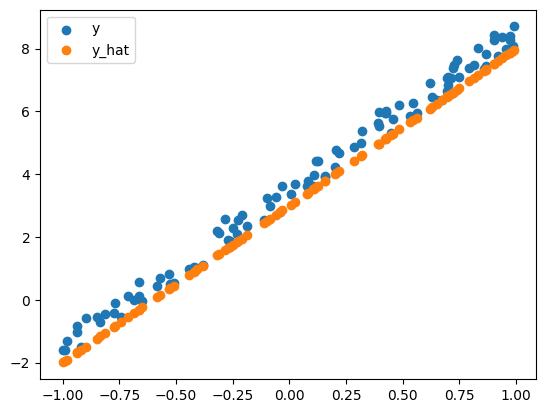

In [8]:
plt.scatter(X[:,0], y, label='y');
plt.scatter(X[:,0], y_hat, label='y_hat');
plt.legend()

### Loss function

Mean Square Error

In [9]:
def mse(y, y_hat): return ((y-y_hat)**2).mean()

Mean Square Root Error

In [10]:
def msre(y, y_hat): return ((y-y_hat)**2).mean().sqrt()

Mean Absolute Error

In [11]:
def mae(y, y_hat): return ((y-y_hat).abs()).mean()

In [12]:
mse(y, X @ W), mae(y, X @ W)

(tensor(0.2987), tensor(0.4702))

#### Visualisation
Let's visualize the loss function landscape as a function of the parameters (i.e. weight and bias)

In [13]:
@np.vectorize
def loss_func(w1, w2, loss=mse):
    W = torch.Tensor([w1, w2])
    y_hat = X @ W
    return loss(y_hat, y)

A helper function to generate samples for the weights

In [14]:
def grid_samples(offset=20, size=100):
    range1 = np.linspace(-offset, offset, size)
    range2 = np.linspace(-offset, offset, size)
    return np.meshgrid(range1, range2)

In [15]:
weights = grid_samples(); print(f'Samples for wights have a shape of {[w.shape for w in weights]}')

Samples for wights have a shape of [(100, 100), (100, 100)]


In [16]:
def plot_loss_funcs(weights, samples, fcts, titles, view=(20, 50)):
    num_fcts = len(fcts)
    fig = plt.figure(figsize=(7 * num_fcts,7))
    for i in range(num_fcts):
        loss = loss_func(*weights, loss=fcts[i])
        ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
        ax.plot_surface(*samples, loss, cmap='viridis', alpha=0.8)
        ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
        ax.set_title(titles[i])
        ax.view_init(*view)


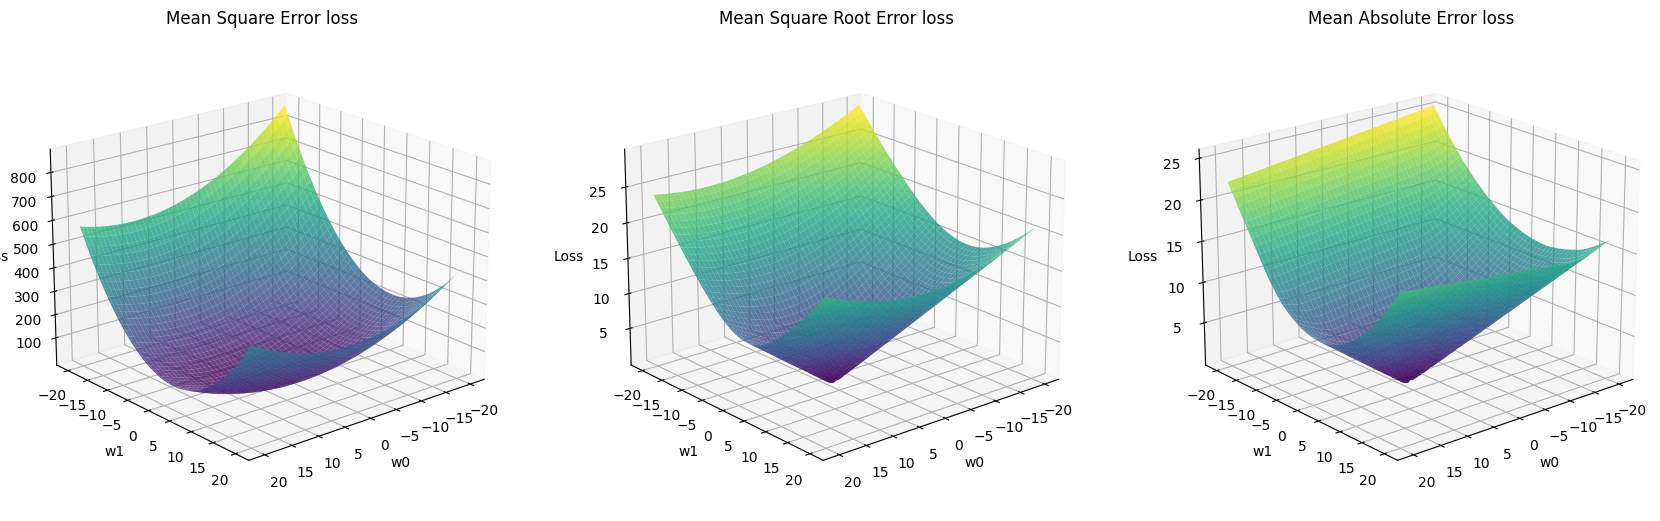

In [17]:
plot_loss_funcs(weights, grid_samples(), fcts=[mse, msre, mae], titles=['Mean Square Error loss', 'Mean Square Root Error loss', 'Mean Absolute Error loss'])

### Optimizers

A simple optimizer that keep tracks of parameters, hyper parameters, and a collection of optimization steps which are supposed to contains the logic for updating parameters.

In [18]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]
        self.steppers = steppers

    def grad_params(self):
        for pg,hyper in zip(self.param_groups,self.hypers):
            for p in pg:
                if p.grad is None: continue
                yield (p,hyper)

    def zero_grad(self):
        for p, hyperp in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p, hyperp in self.grad_params():
            for step in self.steppers: p = step(p, **hyperp)

An optimizer that keep tracks of parameters and their statistics

In [19]:
class StatefulOptimizer(Optimizer):
    def __init__(self, parms, steppers, stats=None, **defaults):
        super().__init__(parms, steppers, **defaults)
        self.stats = stats
        self.state = {}

    def step(self):
        for p, hyperp in self.grad_params():
            if p not in self.state:
                self.state[p] = {}
                for s in self.stats:
                    for k,v in s.init_state(p).items():
                        self.state[p][k] = v
            state = self.state[p]
            for stat in self.stats: state = stat.update(p, state, **hyperp)
            for step in self.steppers: p = step(p, **state, **hyperp)
            self.state[p] = state

A generic class for calculating statistics

In [20]:
class Stat():
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError

Moving Average of Gradadients

In [21]:
class AverageGrad(Stat):
    def __init__(self, dampening=False):
        self.dampening = dampening
    def init_state(self, p):
        return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state

Moving Average of Gradients Squared

In [22]:
class AverageSqrGrad(Stat):
    def __init__(self, dampening=False):
        self.dampening = dampening
    def init_state(self, p):
        return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

Number of the steps so far

In [23]:
class StepCount(Stat):
    def init_state(self, p):
        return {'step': 0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

#### Gradient Descent

In [24]:
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

#### Weight Decay

Weight decay is subtracting $lr*wd*weight$ from the weights.

In [25]:
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p

L2 regularization is adding $wd*weight$ to the gradients.

In [26]:
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p

#### Momentum

In [27]:
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

A specialization for **Stat** class responsible for calculating averages
##### Regular Average

In [28]:
class AverageGrad1(AverageGrad):
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

##### Exponentially Weighted Moving Average

In [29]:
class AverageGrad2(AverageGrad):
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(1-mom, p.grad.data)
        return state

##### Debiased Exponentially Weighted Moving Average

In [30]:
class AverageGrad3(AverageGrad):
    def update(self, p, state, mom, **kwargs):
        ith = state['step'] if 'step' in state else None
        state['grad_avg'].mul_(mom).add_(1-mom, p.grad.data).mul_(1 / (1-mom**(ith+1)))
        return state

#### ADAM

In [31]:
def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

In [32]:
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom, mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p

#### LAMB

In [33]:
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom, mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + wd*p.data
    r2 = step.pow(2).mean().sqrt()
    p.data.add_(-lr * min(r1/r2, 10), step)
    return p

### Training loop

A plain old training loop, eventually refactor this into (begin/end epoch), add some param scheduling

In [34]:
def fit(X, y, epochs=10, w0=[-1, 0], loss_func=mse, opt_func=None):
    loss_history, weights_hisotry = [], []
    W = torch.tensor(w0, requires_grad=True)
    opt = opt_func([W])
    for t in range(epochs):
        # forward
        y_hat = X @ W
        loss = loss_func(y, y_hat)
        weights = W.data.clone()
        # backward
        loss.backward()
        with torch.no_grad():
            opt.step()
            opt.zero_grad()
        # record
        loss_history.append(loss.item())
        weights_hisotry.append(weights)
    weights_hisotry = torch.stack(weights_hisotry)
    return weights_hisotry, loss_history

In [35]:
epochs = 100

# hyper parameters
hyperparams = (dict([('lr', 0.1), ('wd', 0.1), ('mom', 0.9), ('sqr_mom', 0.99), ('eps', 1e-6)]))

# initial parameters (weights)
initial_weights = [-10., -20.]

In [36]:
# SGD
sgd_opt = partial(Optimizer, steppers=[sgd_step], **(hyperparams))
wgts1, losses1 = fit(X, y, epochs=epochs, w0=initial_weights, loss_func=msre, opt_func=sgd_opt)

# SGD + Weight Decay
sgd_wd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step], **(hyperparams))
wgts2, losses2 = fit(X, y, epochs=epochs, w0=initial_weights, loss_func=msre, opt_func=sgd_wd_opt)

# SGD + Weight Decay + Momentum
sgd_mom_opt_1 = partial(StatefulOptimizer, steppers=[momentum_step,weight_decay], stats=[AverageGrad1()], **(hyperparams))
wgts3, losses3 = fit(X, y, epochs=epochs, w0=initial_weights, loss_func=msre, opt_func=sgd_mom_opt_1)

# SGD + Weight Decay + Momentum
sgd_mom_opt_2 = partial(StatefulOptimizer, steppers=[momentum_step,weight_decay], stats=[AverageGrad2()], **(hyperparams))
wgts4, losses4 = fit(X, y, epochs=epochs, w0=initial_weights, loss_func=msre, opt_func=sgd_mom_opt_2)

# SGD + Weight Deay + Momentum (Debiased EWMA)
sgd_mom_opt_3 = partial(StatefulOptimizer, steppers=[momentum_step,weight_decay], stats=[AverageGrad3(), StepCount()], **(hyperparams))
wgts5, losses5 = fit(X, y, epochs=epochs, w0=initial_weights, loss_func=msre, opt_func=sgd_mom_opt_3)

# ADAM
adam_opt = partial(StatefulOptimizer, steppers=[adam_step, weight_decay], stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **(hyperparams))
wgts6, losses6 = fit(X, y, epochs=epochs, w0=initial_weights, loss_func=msre, opt_func=adam_opt)

# LAMB
lamb_opt = partial(StatefulOptimizer, steppers=[lamb_step], stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **(hyperparams))
wgts7, losses7 = fit(X, y, epochs=epochs, w0=initial_weights, loss_func=msre, opt_func=adam_opt)

<ipython-input-24-e80d13734e84>:2: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  p.data.add_(-lr, p.grad.data)


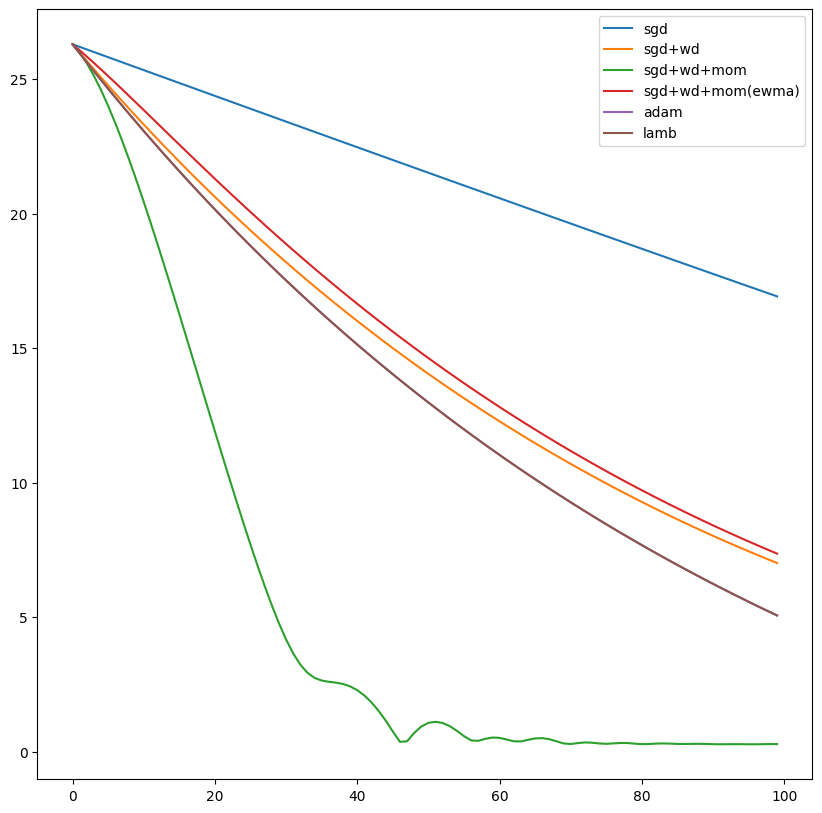

In [37]:
plt.figure(figsize=(10, 10))
plt.plot(losses1, label='sgd')
plt.plot(losses2, label='sgd+wd')
plt.plot(losses3, label='sgd+wd+mom')
plt.plot(losses4, label='sgd+wd+mom(ewma)')
plt.plot(losses6, label='adam')
plt.plot(losses7, label='lamb')
plt.legend()

## Animation

In [38]:
# input for plotting


fcts=[mse, msre, mae]; titles=['Mean Square Error loss', 'Mean Square Root Error loss', 'Mean Absolute Error loss']

i = 1
loss_curve = loss_func(*weights, loss=fcts[i])

max_loss = 30# int(loss_curve.max())
max_weights = max(weights[0].max(), weights[1].max())
min_weights = min(weights[0].min(), weights[1].min())

In [39]:
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 2, width_ratios=[1, 2.5])


# plot ground truth & model
ax0 = fig.add_subplot(gs[0,0])
ax0.scatter(X[:,0], y, c='orange', label='Ground truth')
ax0.set_ylim(-1, 6)
ax0.set_title('Ground truth & Model', fontsize=16)
line0, = ax0.plot([], [], label='Model')
ax0.legend(loc='lower right')

# plot loss (output of the sampling)
ax1 = fig.add_subplot(gs[:,1], projection='3d')
ax1.set_title('Loss', fontsize=16, pad=20)
ax1.plot_surface(*grid_samples(), loss_curve, cmap='viridis', alpha=0.8)
# mark the optimial solution (i.e. target of the training)
ax1.plot3D([W[0]], [W[1]], [0], c='r', marker='x', markersize=10,  label='Target', linewidth=0)
line1, = ax1.plot3D([], [], [], c='r', marker='o', alpha=0.4, label='loss')
ax1.set_xlabel('w0'); ax1.set_ylabel('w1'); ax1.set_zlabel('Loss')
ax1.view_init(50, 70)
ax1.legend()


# plot weights & loss (output of training)
ax2 = fig.add_subplot(gs[1,0])
ax2.set_title('Weights & Loss', fontsize=16)
line2, = ax2.plot([],[], label='w0')
line3, = ax2.plot([],[], label='w1')
ax2.set_ylim(min_weights, max_weights)
ax2.set_xlim(0, epochs)
ax2.set_xlabel('epochs')
ax2.set_ylabel('weights')
ax3 = ax2.twinx()
line4, = ax3.plot([],[], label='loss', c='r')
ax3.set_ylabel('loss')
ax3.set_ybound(0, max_loss)

ax2.legend((line2, line3, line4), ('w0', 'w1', 'loss'), loc='center right')
lr=0.1
title = fig.suptitle(f'lr: {lr} - Epoch: 0/{epochs}', fontsize=22)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.close()


def animate(i):
    line0.set_data(X[:,0].numpy(), (X@wgts[i]).numpy())
    line1.set_data(wgts[:i+1,0].numpy(), wgts[:i+1,1].numpy())
    line1.set_3d_properties(losses[:i+1])
    steps = np.arange(i+1)
    line2.set_data(steps, wgts[:i+1, 0].numpy())
    line3.set_data(steps, wgts[:i+1, 1].numpy())
    line4.set_data(steps, losses[:i+1])
    title.set_text(f'lr: {lr} - Epoch: {i+1}/{epochs}')
    return line0, line1, line2, line3, line4, title

### SGD + Weight Decay + Momentum

In [40]:
wgts = wgts3
losses = np.array(losses3)

max_weights = max(wgts[:, 0].max(), wgts[:, 1].max())
min_weights = min(wgts[:, 0].min(), wgts[:, 1].min())

print(f'Max loss is {max_loss}, Max weights {max_weights} Min weights={min_weights}')
print(f'The solution for wights should be {W}')
print(f'Weights and losses from training: {wgts.shape}, {losses.shape}')

Max loss is 30, Max weights 5.68211030960083 Min weights=-20.0
The solution for wights should be tensor([5., 3.])
Weights and losses from training: torch.Size([100, 2]), (100,)


In [41]:
animation.FuncAnimation(fig, animate, range(epochs), interval=40)

### LAMB

In [42]:
wgts = wgts7
losses = np.array(losses7)
max_loss = max(max_loss, losses.max())

max_weights = max(wgts[0].max(), wgts[1].max())
min_weights = min(wgts[0].min(), wgts[1].min())


print(f'Max loss is {max_loss}, Max weights {max_weights} Min weights={min_weights}')
print(f'The solution for wights should be {W}')
print(f'Weights and losses from training: {wgts.shape}, {losses.shape}')

Max loss is 30, Max weights -9.801000595092773 Min weights=-20.0
The solution for wights should be tensor([5., 3.])
Weights and losses from training: torch.Size([100, 2]), (100,)


In [43]:
animation.FuncAnimation(fig, animate, range(epochs), interval=40)

# Resources
- <a href="https://medium.com/syncedreview/new-google-brain-optimizer-reduces-bert-pre-training-time-from-days-to-minutes-b454e54eda1d">LAMB by Google</a>
- <a href="https://github.com/Jaewan-Yun/optimizer-visualization/tree/master?tab=readme-ov-file"> Optimizer Visuals(Readme to be referred)</a>

- <a href="https://emiliendupont.github.io/2018/01/24/optimization-visualization/"> Interactive Visualizations</a>